# City Geolocator
This notebook generalizes the pipeline developed to crawl and store images from Mapillary for any given city

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
from pathlib import Path
import geopandas as gpd
import wget
from mapillary_crawler import crawl_multipolygon
import time
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib
import urllib.request
from PIL import Image
from shapely.geometry import shape, Point
from matplotlib.ticker import FormatStrFormatter

In [ ]:
ACC_TOK = os.environ.get("MAPILLARY_ACC_TOK")

In [4]:
def get_city(city_name, token):    
    # download the geojson from click_that_hood repository
    if not os.path.exists(city_name+".geojson"):
        site_url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/"+city_name+".geojson"
        file_name = wget.download(site_url)
  
    # geojson file with district information
    city_geojson = city_name+'.geojson'
    df_places = gpd.read_file(city_geojson)
    
    # dataframe (to csv) where to save all crawled images information
    df = pd.DataFrame(columns=['id', 'url', 'lat', 'long', 'district'])
    filename = 'mapillary_raw_'+city_name+'.csv'
    df.to_csv(filename, index=False)
    
    mps = df_places["geometry"].values  # multi-polygons
    bp = Path(city_name)  # basepath
    
    # multi-polygon crawler
    start = time.perf_counter()
    for mp in mps:
        crawl_multipolygon(bp, mp, ACC_TOK, filename, city_geojson, feature='name', force_new_ids=True)
    finish = time.perf_counter()
    print("Finished " + city_name + f"in {round(finish-start, 2)} seconds")

Let's geolocate the images of **[Bari](https://en.wikipedia.org/wiki/Bari)**.

In [3]:
city_name = "bari"
directory = 'mapillary_'+city_name
get_city(city_name, ACC_TOK)

Let's clean our data to download the images.

In [10]:
filename = 'mapillary_raw_'+city_name+'.csv'
df = pd.read_csv(filename)
df = df.drop_duplicates(subset=['url']).reset_index().drop('index', axis=1)
df.to_csv('mapillary_'+city_name+'.csv', index=False)

In [4]:
filename = 'mapillary_'+city_name+'.csv'
df = pd.read_csv(filename)

## Visualize the crawled data

In [5]:
# geojson file with district information
city_geojson = city_name+'.geojson'
df_places = gpd.read_file(city_geojson)

In [6]:
df

,id,url,lat,long,district
0,476623593759530,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.121758,16.783158,San Paolo
1,454683099165339,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.122522,16.782600,San Paolo
2,1183303072189471,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.121787,16.782738,San Paolo
3,1689764171225363,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.122482,16.783374,San Paolo
4,299632268356073,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.122568,16.782475,San Paolo
...,...,...,...,...,...
79981,451711612565728,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.126988,16.857276,Libertá
79982,505122660503340,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.126875,16.857309,Libertá
79983,368792681206541,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.127528,16.859591,Libertá
79984,758915491651807,https://scontent-zrh1-1.xx.fbcdn.net/m1/v/t6/A...,41.128146,16.859254,Libertá


In [7]:
feature='name'  # change this value according to the geojson file you are using
n_images = df['district'].value_counts().rename_axis(feature).reset_index(name='counts')

In [8]:
n_images

,name,counts
0,Japigia,9796
1,Picone,9327
2,Carrassi,7534
3,Murat,7345
4,Marconi,6903
5,Libertá,5967
6,Madonnella,5098
7,Barivecchia,4537
8,San Girolamo,4259
9,Poggiofranco,3951


In [27]:
df_places = df_places.merge(n_images, on=feature, how='left')
df_places['counts'] = df_places['counts'].fillna(0)

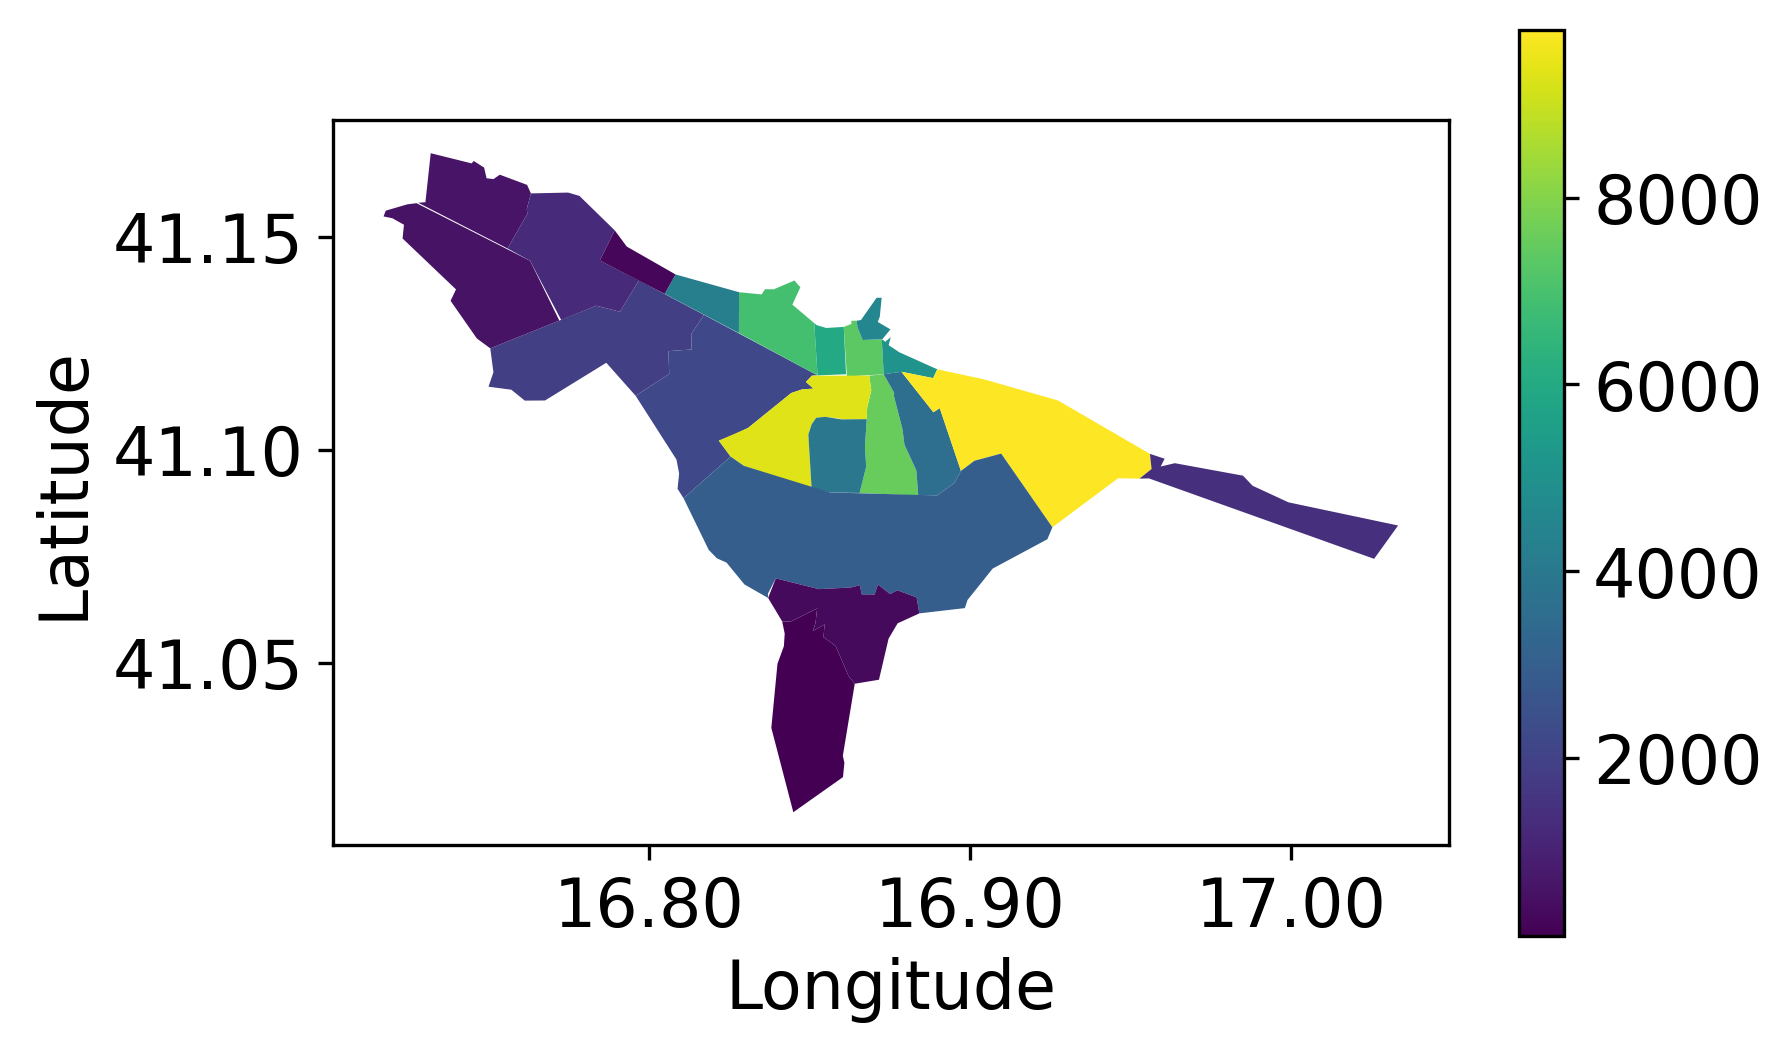

In [37]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size':16})

fig = df_places.plot(column='counts', legend=True)
plt.ylabel('Latitude')
plt.xlabel('Longitude')
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
fig.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig(f'img/mapillary_districts_{city_name}.png')

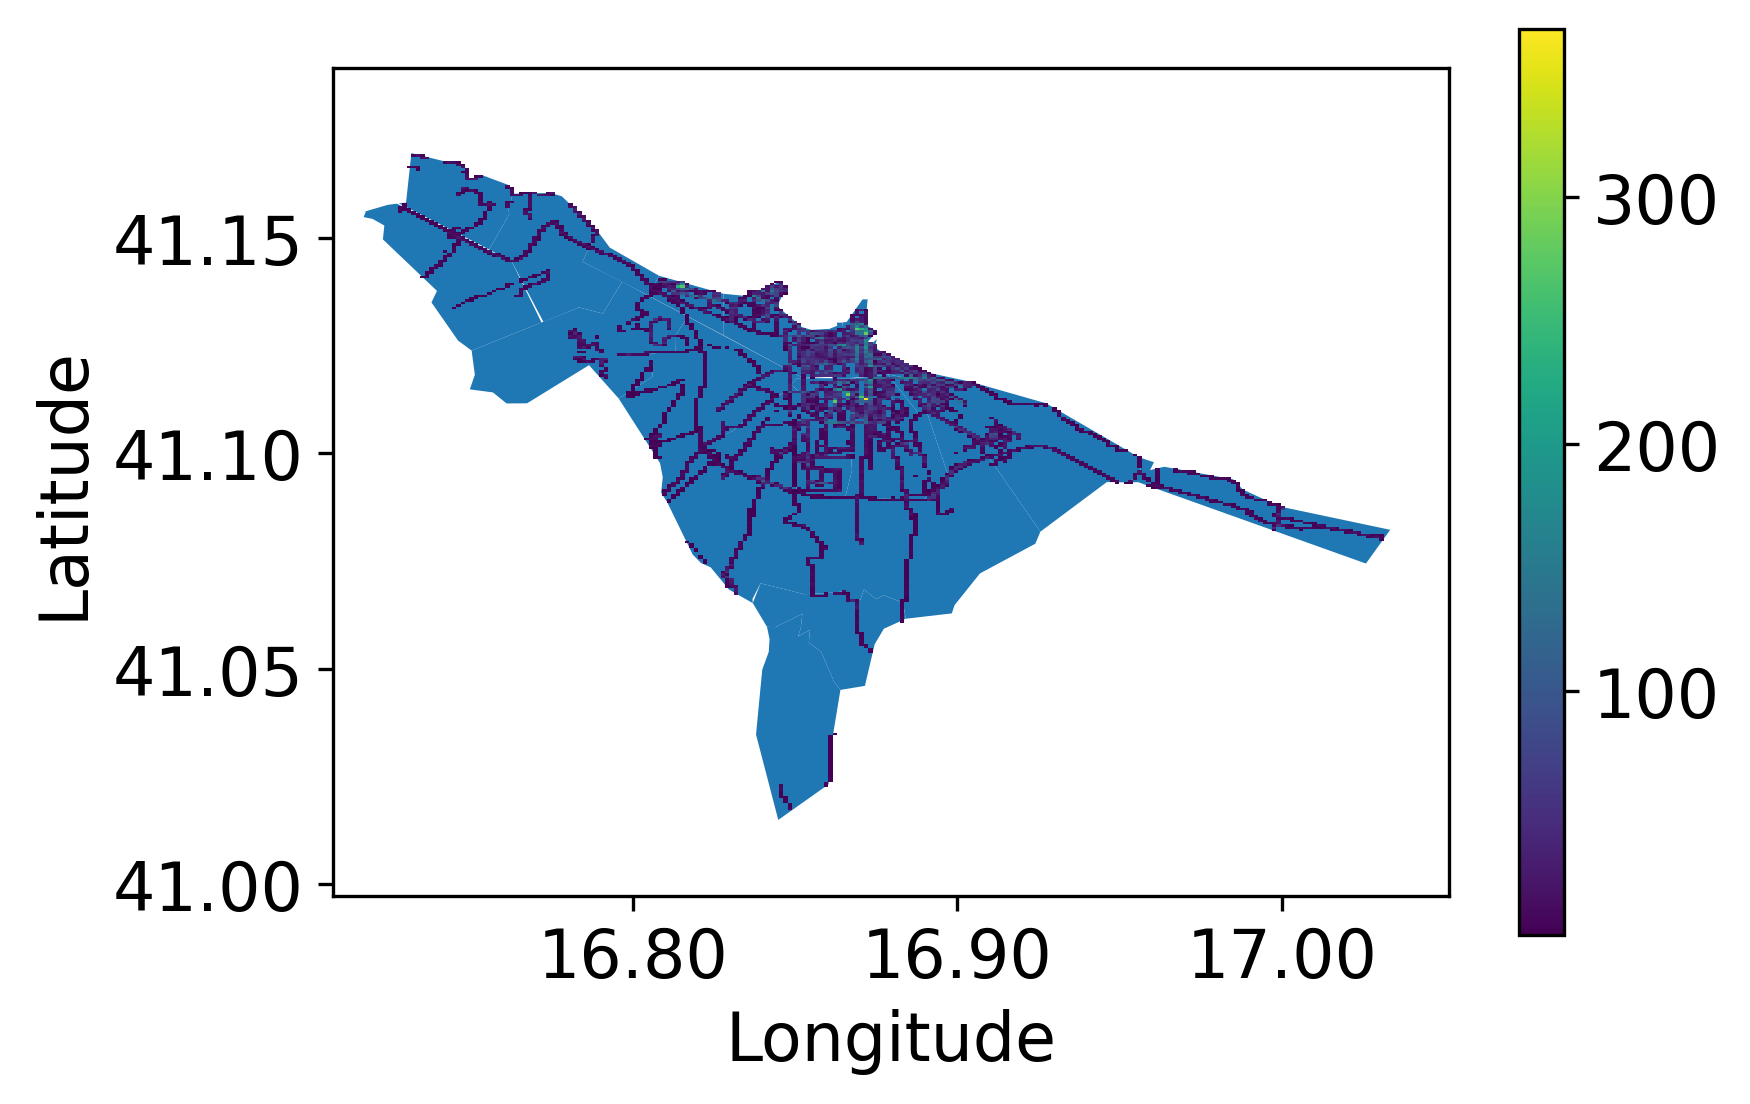

In [51]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size':16})

fig = df_places['geometry'].plot()
plt.hist2d(df['long'],df['lat'], bins=(220,280), cmin=1)  # change bins to your convenience
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
# change xlim and ylim to your convenience
plt.xlim(min(df['long'])-0.02,max(df['long'])+0.02)  
plt.ylim(min(df['lat'])-0.02,max(df['lat'])+0.02)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
fig.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
fig.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# plt.savefig(f'img/mapillary_heatmap_{city_name}.png')

## Download images

Download images into train/val/test folders with 80/10/10 splitting percentage.

In [ ]:
# download images into city_name_mapillary directory
# hint: you can use mapillary_donwloader.py to avoid issues with Jupyter notebook timing execution
directory = 'mapillary_'+city_name

with tqdm(total=df.shape[0]) as pbar: 
    for index, row in df.iterrows():

        if not os.path.exists(f'{directory}/train/{row.district}'):
            os.makedirs(f'{directory}/train/{row.district}')
        if not os.path.exists(f'{directory}/val/{row.district}'):
            os.makedirs(f'{directory}/val/{row.district}')
        if not os.path.exists(f'{directory}/test/{row.district}'):
            os.makedirs(f'{directory}/test/{row.district}')

        path, dirs, files = next(os.walk(f'{directory}/train/{row.district}'))
        path_val, dirs_val, files_val = next(os.walk(f'{directory}/val/{row.district}'))
        file_count = len(files)
        file_count_val = len(files_val)

        # split into 80% training 10% validation 10% test
        if (file_count < (0.8 * len(df[df['district'] == row.district]))):
            path = f'{directory}/train'
        elif (file_count_val < (0.1 * len(df[df['district'] == row.district]))):
            path = f'{directory}/val'
        else:
             path = f'{directory}/test' 

        try:
            urllib.request.urlretrieve(row.url, f'{path}/{row.district}/{index}.jpeg')
            image = Image.open(f'{path}/{row.district}/{index}.jpeg') 
            image = image.resize((256, 256), Image.ANTIALIAS)
            image.save(f'{path}/{row.district}/{index}.jpeg')
        except:
            print("Image not available.")
        pbar.update(1)

print('Download finished!')

In [5]:
# please put num_classes value in config.py at _C.MODEL.NUM_CLASSES before running the training of FocalNet
num_classes = len(os.listdir(directory+'/train'))
print(num_classes)

21


## Start training FocalNets
Execute this command from FocalNet submodule to train *FocalNet tiny srf* model using the city_name images just downloaded. Change params in *config.py* to customize hyper-params for training.

**Be careful!** You need to use the *conda* environment you must have created in order to run the FocalNet, as stated in **[README](https://github.com/IIIA-ML/geoloc#readme)**.

In [ ]:
# Example:
nohup python -m torch.distributed.launch --nproc_per_node 1 --master_port 12347  main.py \
--cfg configs/focalnet_tiny_srf.yaml --data-path mapillary_bari  > execs/output.txt

## Evaluation of the Geolocator
Execute this command from FocalNet submodule to evaluate the predictions of the model just trained. 

**Be careful!** You need to change your test folder name as "val" before running the evaluation process: this is as the FocalNets authors intendend the evaluation process to be carried out (on *val* folder).

In [ ]:
# Example:
python -m torch.distributed.launch --nproc_per_node 1 --master_port 12347 main.py --eval \
--cfg configs/focalnet_tiny_srf.yaml --resume focalnet_tiny_srf.pth --data-path mapillary_bari

## Visualize the results

In [8]:
output_df = pd.read_csv('mapillary_eval.csv')
output_df

,name,target,best prediction,predictions
0,mapillary_bari/val/Carrassi/25414.jpeg,2,11,[ 0.2607422 -1.4042969 1.6806641 -1.854492...
1,mapillary_bari/val/Barivecchia/16091.jpeg,0,0,[ 5.0507812 -0.08056641 0.56152344 -1.024414...
2,mapillary_bari/val/Picone/34670.jpeg,13,2,[-0.3503418 -0.48095703 2.6582031 -1.319335...
3,mapillary_bari/val/Carrassi/25315.jpeg,2,2,[-0.58496094 -0.5810547 5.265625 -1.714843...
4,mapillary_bari/val/San Pasquale/47845.jpeg,17,1,[-0.5493164 2.0625 -0.21362305 -0.483642...
...,...,...,...,...
7851,mapillary_bari/val/San Girolamo/73688.jpeg,15,15,[ 2.4072266e-01 -1.1064453e+00 1.9995117e-01 ...
7852,mapillary_bari/val/Murat/11005.jpeg,11,11,[-0.33398438 -0.8334961 2.0957031 -1.574218...
7853,mapillary_bari/val/San Paolo/1707.jpeg,16,16,[-1.2070312e+00 4.9858093e-03 3.2562256e-02 ...
7854,mapillary_bari/val/Marconi/69141.jpeg,10,10,[ 0.20727539 1.9101562 -0.14794922 -1.276367...


In [13]:
districts = sorted(os.listdir(f'{directory}/train/'))
map = dict(zip(range(0,len(districts)), districts ))

In [16]:
output_df['target'].replace(map, inplace=True)
output_df['best prediction'].replace(map, inplace=True)
output_df

,name,target,best prediction,predictions
0,mapillary_bari/val/Carrassi/25414.jpeg,Carrassi,Murat,[ 0.2607422 -1.4042969 1.6806641 -1.854492...
1,mapillary_bari/val/Barivecchia/16091.jpeg,Barivecchia,Barivecchia,[ 5.0507812 -0.08056641 0.56152344 -1.024414...
2,mapillary_bari/val/Picone/34670.jpeg,Picone,Carrassi,[-0.3503418 -0.48095703 2.6582031 -1.319335...
3,mapillary_bari/val/Carrassi/25315.jpeg,Carrassi,Carrassi,[-0.58496094 -0.5810547 5.265625 -1.714843...
4,mapillary_bari/val/San Pasquale/47845.jpeg,San Pasquale,Carbonara,[-0.5493164 2.0625 -0.21362305 -0.483642...
...,...,...,...,...
7851,mapillary_bari/val/San Girolamo/73688.jpeg,San Girolamo,San Girolamo,[ 2.4072266e-01 -1.1064453e+00 1.9995117e-01 ...
7852,mapillary_bari/val/Murat/11005.jpeg,Murat,Murat,[-0.33398438 -0.8334961 2.0957031 -1.574218...
7853,mapillary_bari/val/San Paolo/1707.jpeg,San Paolo,San Paolo,[-1.2070312e+00 4.9858093e-03 3.2562256e-02 ...
7854,mapillary_bari/val/Marconi/69141.jpeg,Marconi,Marconi,[ 0.20727539 1.9101562 -0.14794922 -1.276367...


In [18]:
df_correctly_pred = output_df[output_df['target']==output_df['best prediction']].reset_index(drop=True)
df_uncorrectly_pred = output_df[output_df['target']!=output_df['best prediction']].reset_index(drop=True)

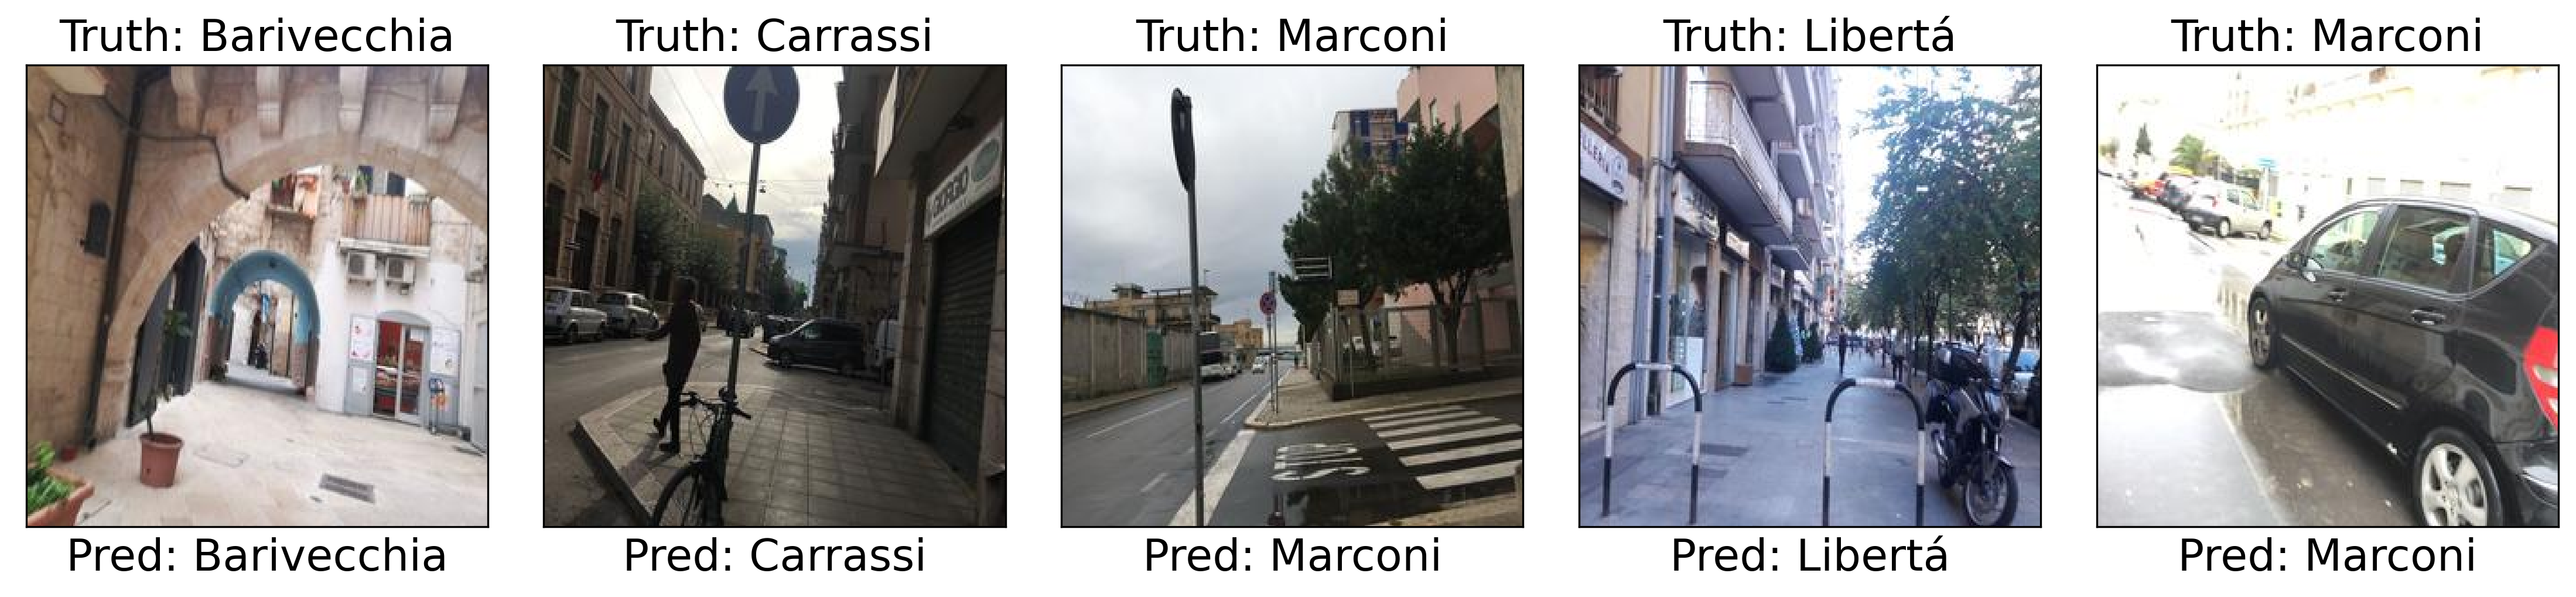

In [19]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = plt.imread(df_correctly_pred['name'][i])
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Truth: {df_correctly_pred.target[i]}", fontsize=18)
    plt.xlabel(f"Pred: {df_correctly_pred['best prediction'][i]}", fontsize=18)          
plt.tight_layout()
plt.savefig(f'img/correct_images_{city_name}.png')

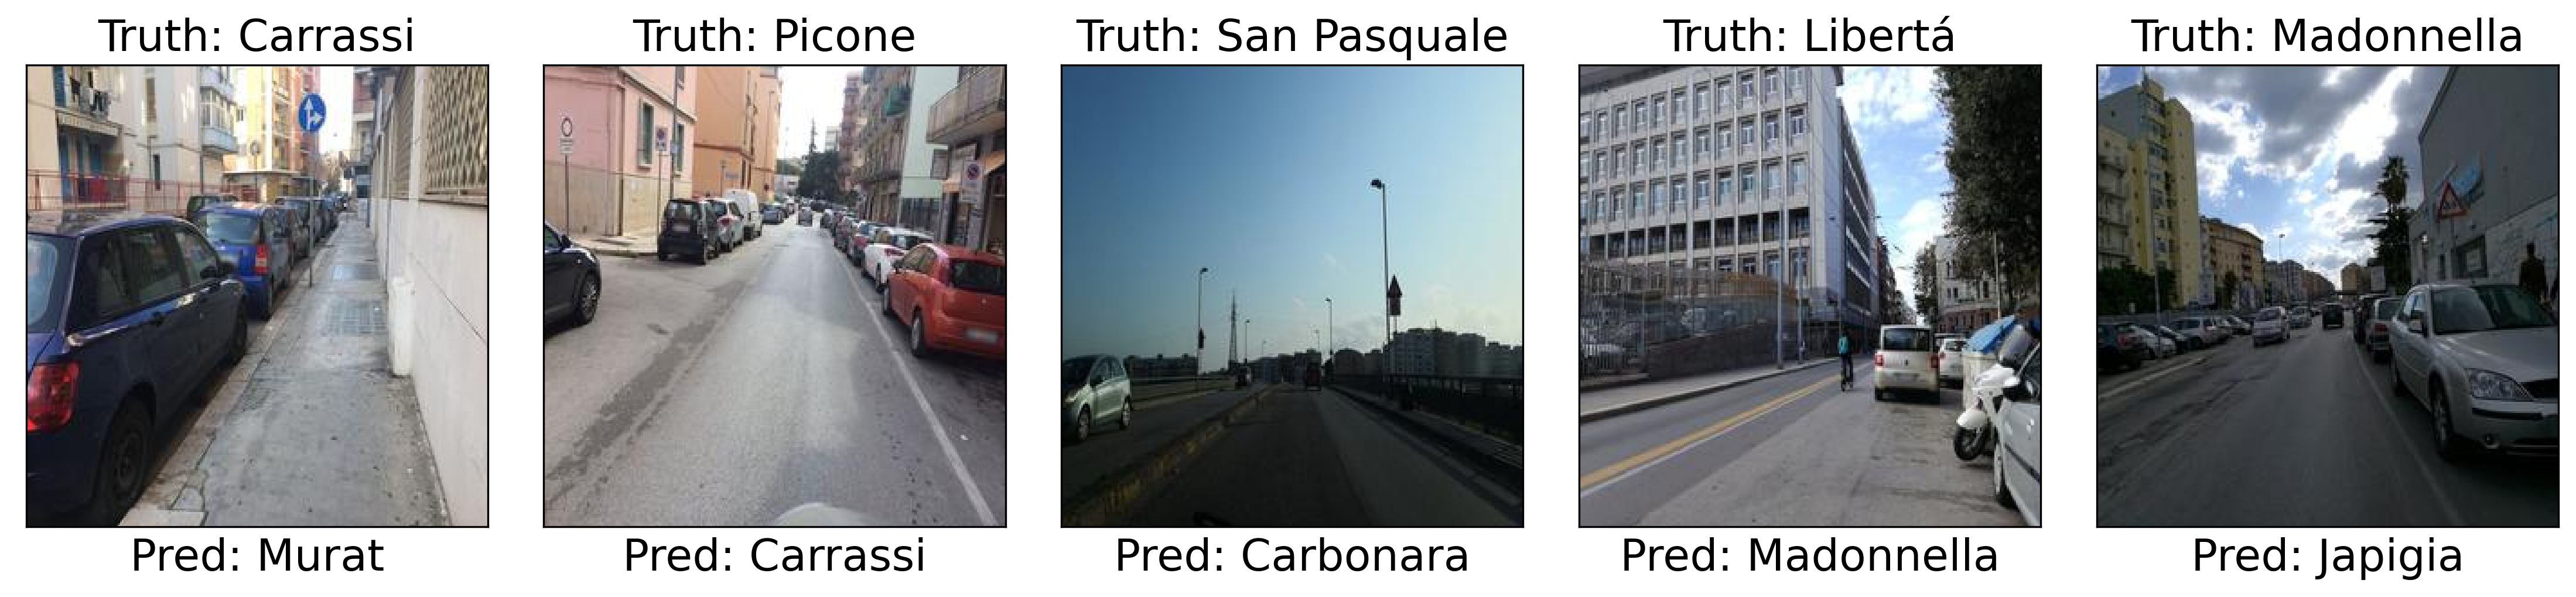

In [20]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    image = plt.imread(df_uncorrectly_pred['name'][i])
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Truth: {df_uncorrectly_pred.target[i]}", fontsize=18)
    plt.xlabel(f"Pred: {df_uncorrectly_pred['best prediction'][i]}", fontsize=18)          
plt.tight_layout()
plt.savefig(f'img/uncorrect_images_{city_name}.png')